
# Tutorial: Tail Preprocessing 	&#x1F42C;

**The following notebook illustrate the `TailPreprocessing` class how to run the different preprocessing steps.**
- **Several preprocessing steps are used for the tail angle**:
  - Interpolating missing values
  - PCA denoising of posture using 'eigen-fish'
  - Savgol filter for time series smoothing
  - Baseline correction

- **The tail vigor is also computed and will also be useful for segmentation tail bouts**:



* Loading dependencies

In [15]:
from IPython.display import SVG, display

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from megabouts.tracking_data.tracking_data import TrackingConfig
from megabouts.tracking_data.load_example import load_example_data
from megabouts.tracking_data.tracking_data import FullTrackingData

from megabouts.preprocessing.tail_preprocessing import TailPreprocessingConfig
from megabouts.preprocessing.tail_preprocessing import TailPreprocessingResult
from megabouts.preprocessing.tail_preprocessing import TailPreprocessing

## Loading Data

* TrackingConfig and TrackingData similar to [tutorial_Loading_Data](./tutorial_Loading_Data.ipynb)

In [16]:
df_recording, fps, mm_per_unit = load_example_data('fulltracking_posture')

tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')

head_x = df_recording['head_x'].values*mm_per_unit
head_y = df_recording['head_y'].values*mm_per_unit
head_yaw = df_recording['head_angle'].values
tail_angle = df_recording.filter(like='tail_angle').values

tracking_data = FullTrackingData.from_posture(head_x = head_x,
                                              head_y = head_y,
                                              head_yaw = head_yaw,
                                              tail_angle = tail_angle)

## Run Preprocessing

* Define preprocessing config using default:

In [17]:
tail_preprocessing_cfg = TailPreprocessingConfig(fps=tracking_cfg.fps)

* Alternatively the tail preprocessing parameters can be adjusted using:

In [18]:
tail_preprocessing_cfg = TailPreprocessingConfig(fps=tracking_cfg.fps,
                                                 num_pcs=4,
                                                 savgol_window_ms=15,
                                                 tail_speed_filter_ms = 100,
                                                 tail_speed_boxcar_filter_ms = 14
                                                 )

In [19]:
tail_df_input = tracking_data.tail_df
tail = TailPreprocessing(tail_preprocessing_cfg).preprocess_tail_df(tail_df_input)

In [20]:
tail.df.head(5)

angle                                                              \
   segments                                                               
          0         1         2         3         4         5         6   
0 -0.101865 -0.092813 -0.107645 -0.110575 -0.047699 -0.145887 -0.130414   
1 -0.082618 -0.087957 -0.096951 -0.092459 -0.119418 -0.043354 -0.099788   
2 -0.093377 -0.095235 -0.094292 -0.105936 -0.073785 -0.084193 -0.144378   
3 -0.092590 -0.083650 -0.100938 -0.088223 -0.097370 -0.099559 -0.101538   
4 -0.086849 -0.081982 -0.096705 -0.118475 -0.046264 -0.136459 -0.115412   

                           ... angle_smooth                                \
                           ...     segments                                 
          7         8   9  ...            2         3         4         5   
0 -0.058892 -0.128705 NaN  ...    -0.086812 -0.085880 -0.077907 -0.083591   
1 -0.101741 -0.171555 NaN  ...    -0.081511 -0.083338 -0.078373 -0.085253   
2 -0.112398 -0.042585 NaN  ...    -0.077037 -0.081058 -0.078500 -0.086296   
3 -0.091272 -0.021459 NaN  ...    -0.073390 -0.079040 -0.078286 -0.086720   
4 -0.085300 -0.015487 NaN  ...    -0.070570 -0.077285 -0.077732 -0.086525   

                                          vigor no_tracking  
                                                             
          6         7         8         9                    
0 -0.072974 -0.078165 -0.129616  0.000359   NaN        True  
1 -0.074040 -0.073428 -0.106065  0.000494   NaN        True  
2 -0.074570 -0.069208 -0.086540  0.000602   NaN        True  
3 -0.074562 -0.065506 -0.071041  0.000682   NaN        True  
4 -0.074018 -0.062321 -0.059569  0.000734   NaN        True  

[5 rows x 32 columns]

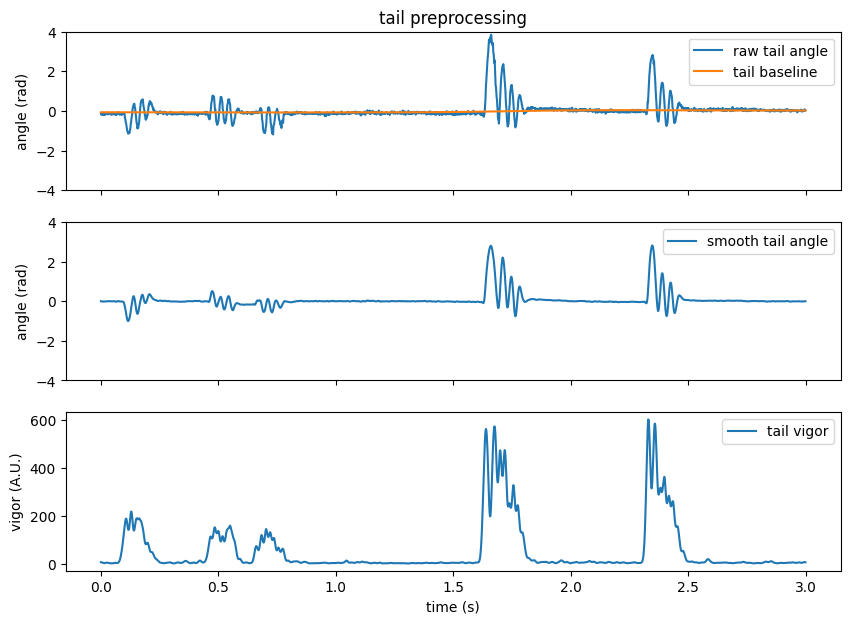

In [21]:
t = np.arange(tracking_data.T)/tracking_cfg.fps
IdSt = np.random.randint(tracking_data.T)
Duration = 3*tracking_cfg.fps

t_win = t[IdSt:IdSt+Duration]-t[IdSt]
fig,ax = plt.subplots(3,1,figsize=(10,7),sharex=True)
ax[0].plot(t_win,tail.angle[IdSt:IdSt+Duration,7],label='raw tail angle')
ax[0].plot(t_win,tail.angle_baseline[IdSt:IdSt+Duration,7],label='tail baseline')
ax[1].plot(t_win,tail.angle_smooth[IdSt:IdSt+Duration,7],label='smooth tail angle')
ax[2].plot(t_win,tail.vigor[IdSt:IdSt+Duration],label='tail vigor')
ax[0].set(title='tail preprocessing',ylabel='angle (rad)',ylim=(-4,4))
ax[1].set(ylabel='angle (rad)',ylim=(-4,4))
ax[2].set(xlabel='time (s)',ylabel='vigor (A.U.)')

for i in range(3):
    ax[i].legend()
plt.show()